# XGBoost Regression ALL DISTRICTS

In [265]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pathlib import Path
import xgboost as xgb
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [296]:
data_dir = "../../preprocessed/" 
features_dir = data_dir + "district_features/regression/"
# labels_dir = data_dir + "labels/" 

LABELING_METHOD = "threshold"
AVERAGING_METHOD = "kaist"

model_dir = "../../resources/districts/" 

PCA_components = 16

USE_GEO = "NO"

if USE_GEO == "GEO":
    features_columns = ["PCA"+str(i) for i in range(PCA_components)] + \
                        ["centroid_x", "centroid_y"]
else:
    features_columns = ["PCA"+str(i) for i in range(PCA_components)]
    

label_columns = ["hType_mix", "num_intersect", "bld_avg_age", "emp_rat_num",\
				"LUM5_single",	"RNR_nres", "mdist_smallparks", "nig_rat_daily",\
				"nig_rat_daily3", "mdist_nres_daily", "num_community_places", \
				"num_community_places_poi", "avg_block_area", "sphi", \
				"enterprises_empl_size", "pop_rat_num",  \
				"emp_rat_pop", "den_nres_daily",\
				"mdist_parks", "den_nres_non-daily", "mdist_railways",\
				"mdist_highways", "mdist_water", "activity_density"]

JJ_features_columns = ["label_" + c for c in label_columns if c != "activity_density"]        

network_type = "vgg16_4096"

In [297]:
label_columns = ["hType_mix", "num_intersect", "bld_avg_age", "emp_rat_num",\
				"LUM5_single",	"RNR_nres", "mdist_smallparks", "nig_rat_daily",\
				"nig_rat_daily3", "mdist_nres_daily", "num_community_places", \
				"num_community_places_poi", "avg_block_area", "sphi", \
				"enterprises_empl_size", "pop_rat_num",  \
				"emp_rat_pop", "den_nres_daily",\
				"mdist_parks", "den_nres_non-daily", "mdist_railways",\
				"mdist_highways", "mdist_water", "activity_density"] # "bld_rat_area", 

In [298]:
land_use = [
"LUM5_single","RNR_nres","mdist_smallparks",
"hType_mix", "nig_rat_daily", "mdist_nres_daily",
"num_community_places", "num_community_places_poi"]


small_blocks = [
"avg_block_area","num_intersect", "sphi"]


age_buildings = [
"bld_avg_age","enterprises_empl_size"]

concentration = [
"pop_rat_num","emp_rat_num","emp_rat_pop"
    ,"den_nres_daily","den_nres_non-daily"]

vacuums = [
"mdist_parks", "mdist_railways",
"mdist_highways", "mdist_water"]

## Functions

In [299]:
def get_normalized_labels_features():
    if network_type == "vgg19":
        df = pd.read_csv(features_dir + "Italy_6_cities_vgg19_pca"+str(PCA_components)+"_linear_fc_thirdlast_layer_labels_features.csv")
    elif network_type == "resnet50":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca"+str(PCA_components)+"_second_last_layer_labels_features.csv")
    elif network_type == "vgg16_4096":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca" + str(PCA_components) + "_vgg16_4096_"\
                         + LABELING_METHOD + "_" + AVERAGING_METHOD + "_labels_features.csv")

    df["label_district"] = df["label_district"].astype(str)
    df["city_district"] = df.\
        apply(lambda x: x.city + "_" + x.label_district, axis = 1)
    try:
        del df['index']
    except:
        pass
    return df

In [300]:
def predict_label_i(label="label_activity_density"):
    
    data2 = data.copy()
    
    target = data2[["city_district", label]]
    features = data2[features_columns]
    
    X = features.values
    y = target[label].values
    
    param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
    clf = xgb.XGBRegressor(**param_dist)

    clf.fit(X, y,verbose=False)
    
#     pickle.dump(clf, open(model_dir + label + '_all_reg.dat' , "wb"))
    
    print(clf.score(X, y))

In [301]:
def predict_JJ_f_label_i_KFold(label="label_hType_mix"):
    
    kf = KFold(n_splits=5)

    data2 = data[["city_district", label] + features_columns + JJ_features_columns].copy()
    data2 = data2.dropna()
      
    target = data2[["city_district", label]]
    features = data2[features_columns + JJ_features_columns]
    
    X = features.values
    y = target[label].values
 
    rmse = []
    r2 = []
    mae = []
    
    kf.get_n_splits(X, y)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
        clf = xgb.XGBRegressor(**param_dist)
        
        clf.fit(X_train, y_train,verbose=False)
        
        predictions = clf.predict(X_test)
        rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmse.append(rmse1)
        
        r21 = r2_score(y_test, predictions)
        r2.append(r21)
        
        mae1 = mean_absolute_error(y_test, predictions)
        mae.append(mae1)
        
        plt.scatter(y_test, predictions)
        print(r21)
        
        def plot_bad_res():
            error = (y_test - predictions)**2
            print ( min(error), max(error) )

            y_error = [y_test[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == max(error) ]
            y_pred_wrong = [predictions[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == max(error) ]
            print (y_error, y_pred_wrong)
            print (target[target[label].isin(y_error)])
        
        plot_bad_res()
        
#     pickle.dump(clf, open(model_dir + label + 'reg.dat' , "wb"))

        
    return  ({"MAE": (np.mean(mae), np.std(mae)), \
              "R2": (np.mean(r2), np.std(r2)), "RMSE": (np.mean(rmse), np.std(rmse))},
             {"RMSE": np.mean(rmse), "R2": np.mean(r2), "MAE": np.mean(mae)})

In [302]:
def predict_Pop_Dens_label_i_KFold(label="label_hType_mix"):
    
    kf = KFold(n_splits=5)

    data2 = data[["city_district", label] + features_columns + ["label_pop_rat_num"]].copy()
    data2 = data2.dropna()
      
    target = data2[["city_district", label]]
    features = data2[features_columns + ["label_pop_rat_num"]]
    
    X = features.values
    y = target[label].values
 
    rmse = []
    r2 = []
    mae = []
    
    kf.get_n_splits(X, y)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
        clf = xgb.XGBRegressor(**param_dist)
        
        clf.fit(X_train, y_train,verbose=False)
        
        predictions = clf.predict(X_test)
        
        rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmse.append(rmse1)
        
        r21 = r2_score(y_test, predictions)
        r2.append(r21)
        
        mae1 = mean_absolute_error(y_test, predictions)
        mae.append(mae1)
        
        
        plt.scatter(y_test, predictions)
        print(r21)
        
#     pickle.dump(clf, open(model_dir + label + 'reg.dat' , "wb"))

        
    return  ({"MAE": (np.mean(mae), np.std(mae)), \
              "R2": (np.mean(r2), np.std(r2)), "RMSE": (np.mean(rmse), np.std(rmse))},
             {"RMSE": np.mean(rmse), "R2": np.mean(r2), "MAE": np.mean(mae)})

In [303]:
def predict_baseline_Pop_Dens_label_i_KFold(city='all', label="label_hType_mix"):
    
    kf = KFold(n_splits=5)
    
    if city == 'all':
        data2 = data.copy()
    else:
        data2 = data[data["city"] == city]

    data2 = data2[["city_district", label] + ["label_pop_rat_num"]].copy()
    data2 = data2.dropna()
      
    target = data2[["city_district", label]]
    features = data2[["label_pop_rat_num"]]
    
    X = features.values
    y = target[label].values
 
    rmse = []
    r2 = []
    mae = []
    
    kf.get_n_splits(X, y)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
        clf = xgb.XGBRegressor(**param_dist)
        
        clf.fit(X_train, y_train,verbose=False)
        
        predictions = clf.predict(X_test)
        
        rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmse.append(rmse1)
        
        r21 = r2_score(y_test, predictions)
        r2.append(r21)
          
        plt.scatter(y_test, predictions)
        print(r21)
        
        mae1 = mean_absolute_error(y_test, predictions)
        mae.append(mae1)
        
#     pickle.dump(clf, open(model_dir + label + 'reg.dat' , "wb"))

        
    return  ({"MAE": (np.mean(mae), np.std(mae)), \
              "R2": (np.mean(r2), np.std(r2)), "RMSE": (np.mean(rmse), np.std(rmse))},
             {"RMSE": np.mean(rmse), "R2": np.mean(r2), "MAE": np.mean(mae)})

In [304]:
def predict_label_i_KFold(label="label_hType_mix"):
    
    kf = KFold(n_splits=5)
    
    data2 = data.copy()
    target = data2[["city_district", label]]
    features = data2[features_columns]
    
    X = features.values
    y = target[label].values
 
    rmse = []
    r2 = []
    mae = []
    
    kf.get_n_splits(X, y)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
        clf = xgb.XGBRegressor(**param_dist)
        
        clf.fit(X_train, y_train,verbose=False)
        
        predictions = clf.predict(X_test)
        rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmse.append(rmse1)
        
        r21 = r2_score(y_test, predictions)
        r2.append(r21)
        
        mae1 = mean_absolute_error(y_test, predictions)
        mae.append(mae1)
        
        plt.scatter(y_test, predictions)
        print(r21)
        
        def plot_bad_res():
            error = (y_test - predictions)**2
            print ( min(error), max(error) )

            y_error = [y_test[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == max(error) ]
            y_pred_wrong = [predictions[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == max(error) ]
            print (y_error, y_pred_wrong)
            print (target[target[label].isin(y_error)])
        
        def plot_good_res():
            error = (y_test - predictions)**2
            print ( min(error), max(error) )

            y_correct = [y_test[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == min(error) ]
            y_pred_corr = [predictions[i] for i in range(len(y_test)) if (y_test[i] - predictions[i])**2 == min(error) ]
            print (y_correct, y_pred_corr)
            print (target[target[label].isin(y_correct)])
            
#         plot_good_res()
        
#     pickle.dump(clf, open(model_dir + label + 'reg.dat' , "wb"))

        
    return  ({"MAE": (np.mean(mae), np.std(mae)), \
              "R2": (np.mean(r2), np.std(r2)), "RMSE": (np.mean(rmse), np.std(rmse))},
             {"RMSE": np.mean(rmse), "R2": np.mean(r2), "MAE": np.mean(mae)})

## Read in Data. Chose standardized or not.

In [305]:
data = get_normalized_labels_features()

In [322]:
USE_GEO = "GEO"
if AVERAGING_METHOD == "kaist":
    features_columns = [c for c in data.columns if "PCA" in c]
    if USE_GEO == "GEO":
        features_columns = features_columns + ['f_centroid_x', 'f_centroid_y']

## Predict K-Fold

In [323]:
data[['label_activity_density']].describe()

,label_activity_density
count,370.000000
mean,0.530876
std,0.240842
min,0.000000
25%,0.344373
50%,0.531198
75%,0.713751
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b542150>]],
      dtype=object)

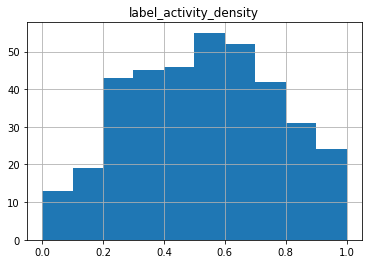

In [324]:
data[['label_activity_density']].hist()

In [325]:
len(data)

370

In [326]:
data.columns

Index(['label_district', 'f_std_PCA0', 'f_std_PCA1', 'f_std_PCA2',
       'f_std_PCA3', 'f_std_PCA4', 'f_std_PCA5', 'f_std_PCA6', 'f_std_PCA7',
       'f_std_PCA8', 'f_std_PCA9', 'f_std_PCA10', 'f_std_PCA11', 'f_std_PCA12',
       'f_std_PCA13', 'f_std_PCA14', 'f_std_PCA15', 'f_avg_PCA0', 'f_avg_PCA1',
       'f_avg_PCA2', 'f_avg_PCA3', 'f_avg_PCA4', 'f_avg_PCA5', 'f_avg_PCA6',
       'f_avg_PCA7', 'f_avg_PCA8', 'f_avg_PCA9', 'f_avg_PCA10', 'f_avg_PCA11',
       'f_avg_PCA12', 'f_avg_PCA13', 'f_avg_PCA14', 'f_avg_PCA15', 'f_count',
       'f_centroid_x', 'f_centroid_y', 'label_hType_mix',
       'label_num_intersect', 'label_bld_avg_age', 'label_emp_rat_num',
       'label_LUM5_single', 'label_RNR_nres', 'label_mdist_smallparks',
       'label_nig_rat_daily', 'label_nig_rat_daily3', 'label_mdist_nres_daily',
       'label_num_community_places', 'label_num_community_places_poi',
       'label_avg_block_area', 'label_sphi', 'label_enterprises_empl_size',
       'label_pop_rat_num', 'labe

In [327]:
features_columns

['f_std_PCA0',
 'f_std_PCA1',
 'f_std_PCA2',
 'f_std_PCA3',
 'f_std_PCA4',
 'f_std_PCA5',
 'f_std_PCA6',
 'f_std_PCA7',
 'f_std_PCA8',
 'f_std_PCA9',
 'f_std_PCA10',
 'f_std_PCA11',
 'f_std_PCA12',
 'f_std_PCA13',
 'f_std_PCA14',
 'f_std_PCA15',
 'f_avg_PCA0',
 'f_avg_PCA1',
 'f_avg_PCA2',
 'f_avg_PCA3',
 'f_avg_PCA4',
 'f_avg_PCA5',
 'f_avg_PCA6',
 'f_avg_PCA7',
 'f_avg_PCA8',
 'f_avg_PCA9',
 'f_avg_PCA10',
 'f_avg_PCA11',
 'f_avg_PCA12',
 'f_avg_PCA13',
 'f_avg_PCA14',
 'f_avg_PCA15',
 'f_centroid_x',
 'f_centroid_y']

0.11213862003917419
0.38345119656940163
0.38238822855641486
0.29188622028106503
0.28062982937110925


({'MAE': (0.16100733411716586, 0.01283043123370367),
  'R2': (0.29009881896343304, 0.0989895858120844),
  'RMSE': (0.19800284956543887, 0.012721945126575256)},
 {'RMSE': 0.19800284956543887,
  'R2': 0.29009881896343304,
  'MAE': 0.16100733411716586})

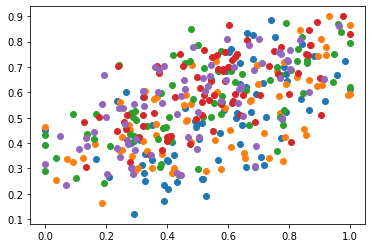

In [328]:
predict_label_i_KFold('label_activity_density')

0.7330245335844308
1.3580343603965722e-06 0.10029489543897174
[0.0] [0.3166937]
    city_district  label_activity_density
52      milano_53                     0.0
121    palermo_54                     0.0
175    torino_153                     0.0
189    bologna_11                     0.0
213    firenze_32                     0.0
357      roma_138                     0.0
0.727966948733213
2.404713463891619e-06 0.16520645054924987
[0.0] [0.40645596]
    city_district  label_activity_density
52      milano_53                     0.0
121    palermo_54                     0.0
175    torino_153                     0.0
189    bologna_11                     0.0
213    firenze_32                     0.0
357      roma_138                     0.0
0.7244051413479533
5.203841879133058e-05 0.20882478597467094
[0.6676845688175012] [0.21071106]
    city_district  label_activity_density
197    bologna_62                0.667685
0.7550203449611754
2.5842239851416292e-06 0.08053040846691616
[0.550412521

({'MAE': (0.09514674684828615, 0.010357835225660852),
  'R2': (0.738418758568256, 0.012538807240268695),
  'RMSE': (0.12133986101829893, 0.015062738187180208)},
 {'RMSE': 0.12133986101829893,
  'R2': 0.738418758568256,
  'MAE': 0.09514674684828615})

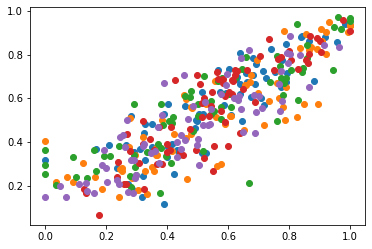

In [329]:
 predict_JJ_f_label_i_KFold('label_activity_density')

0.1932677736528544
0.40522769647054313
0.3699647508862829
0.2143243108940972
0.3842027363588262


({'MAE': (0.15541658908204886, 0.012920131511244595),
  'R2': (0.31339745365252075, 0.09043524567813456),
  'RMSE': (0.1947076062214351, 0.011478531352644481)},
 {'RMSE': 0.1947076062214351,
  'R2': 0.31339745365252075,
  'MAE': 0.15541658908204886})

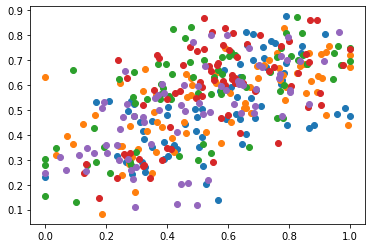

In [28]:
predict_Pop_Dens_label_i_KFold('label_activity_density')

0.04066166237133728
0.34895997897645814
0.2840551992488163
0.007058777268060812
0.33205043045384064


({'MAE': (0.17008467429918797, 0.00974102961762866),
  'R2': (0.20255720966370264, 0.14783368540472125),
  'RMSE': (0.20893184120722835, 0.011504330356573026)},
 {'RMSE': 0.20893184120722835,
  'R2': 0.20255720966370264,
  'MAE': 0.17008467429918797})

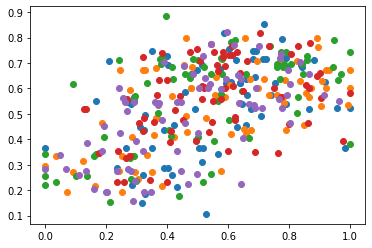

In [34]:
predict_baseline_Pop_Dens_label_i_KFold(label='label_activity_density')

In [142]:
predict_label_i('label_activity_density')

0.9887280988318915


In [143]:
kfold_SCORES = {}
kfold_SCORES2 = {}
for col in label_columns:
    label = "label_" + col
    res1, res2 = predict_label_i_KFold(label)
    kfold_SCORES[label] = res1
    kfold_SCORES2[label] = res2

In [144]:
kfold_SCORES

{'label_hType_mix': {'MAE': (0.17889293136717335, 0.039130040376591645),
  'R2': (0.06393174845398279, 0.2231455657180369),
  'RMSE': (0.22977718513480366, 0.044372714621706985)},
 'label_num_intersect': {'MAE': (0.13080363166979422, 0.01854911606822666),
  'R2': (0.5137391034696873, 0.08017730266327436),
  'RMSE': (0.1707917707154985, 0.023240095807490466)},
 'label_bld_avg_age': {'MAE': (0.17346970331832745, 0.012603925915098318),
  'R2': (0.1853379705747223, 0.12393812444721466),
  'RMSE': (0.21796452687727635, 0.015307226595108834)},
 'label_emp_rat_num': {'MAE': (0.14206118478933746, 0.01195182196628203),
  'R2': (0.30092038215434236, 0.035860605120956485),
  'RMSE': (0.17978662559386632, 0.01346115697853015)},
 'label_LUM5_single': {'MAE': (0.20917402599209134, 0.011610334716208448),
  'R2': (0.006663224012698055, 0.14725042354310594),
  'RMSE': (0.2567854666956247, 0.01116498740143294)},
 'label_RNR_nres': {'MAE': (0.24146429326254584, 0.02256146670356747),
  'R2': (-0.180567775

In [145]:
res = pd.DataFrame(kfold_SCORES2)

In [146]:
res

,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,label_mdist_nres_daily,...,label_enterprises_empl_size,label_pop_rat_num,label_emp_rat_pop,label_den_nres_daily,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density
MAE,0.178893,0.130804,0.173470,0.142061,0.209174,0.241464,0.180425,0.182790,0.147031,0.158958,...,0.192631,0.094734,0.172695,0.170831,0.217587,0.143065,0.205695,0.190596,0.219034,0.164392
R2,0.063932,0.513739,0.185338,0.300920,0.006663,-0.180568,-0.343659,-0.435857,-0.581075,0.390381,...,-0.002716,0.713196,-0.100203,0.426611,-0.313518,0.318538,-0.110837,0.016675,-0.313776,0.239218
RMSE,0.229777,0.170792,0.217965,0.179787,0.256785,0.289403,0.225482,0.232745,0.219170,0.195921,...,0.239288,0.121514,0.219391,0.211676,0.262044,0.193062,0.251534,0.235453,0.266697,0.205996


In [112]:
res_name = '../../results/districts/regression/k-fold/'\
    + str(PCA_components) +  '_' + 'inference.csv'
    
res.to_csv(res_name, float_format='%.3f')

In [117]:
kfold_SCORES3 = {}
kfold_SCORES4 = {}
for col in label_columns:
    label = "label_" + col
    print (col)
    try:
        res1, res2 = predict_Pop_Dens_label_i_KFold(label)
        kfold_SCORES3[label] = res1
        kfold_SCORES4[label] = res2
    except:
        continue

hType_mix
num_intersect
bld_avg_age
emp_rat_num
LUM5_single
RNR_nres
mdist_smallparks
nig_rat_daily
nig_rat_daily3
mdist_nres_daily
num_community_places
num_community_places_poi
avg_block_area
sphi
enterprises_empl_size
pop_rat_num
emp_rat_pop
den_nres_daily
mdist_parks
den_nres_non-daily
mdist_railways
mdist_highways
mdist_water
activity_density


In [118]:
kfold_SCORES4

{'label_hType_mix': {'RMSE': 0.2279408694267379,
  'R2': 0.07051422133629157,
  'MAE': 0.17965797829028501},
 'label_num_intersect': {'RMSE': 0.15842174057163844,
  'R2': 0.5814610881877643,
  'MAE': 0.12266114263799985},
 'label_bld_avg_age': {'RMSE': 0.2263119522213139,
  'R2': 0.12493259950546103,
  'MAE': 0.1833325479429063},
 'label_emp_rat_num': {'RMSE': 0.1803000195304037,
  'R2': 0.2947749648765722,
  'MAE': 0.1430904185745781},
 'label_LUM5_single': {'RMSE': 0.24911881165039537,
  'R2': 0.04462164704879985,
  'MAE': 0.20199669155547686},
 'label_RNR_nres': {'RMSE': 0.28897066689661677,
  'R2': -0.18348239550738177,
  'MAE': 0.234880230695338},
 'label_mdist_smallparks': {'RMSE': 0.22152740181457045,
  'R2': -0.27021421772457926,
  'MAE': 0.17651944813052456},
 'label_nig_rat_daily': {'RMSE': 0.23329026433756153,
  'R2': -0.4119039442902115,
  'MAE': 0.17968763783441738},
 'label_nig_rat_daily3': {'RMSE': 0.21824987192003936,
  'R2': -0.837768583203507,
  'MAE': 0.1420760323386

In [119]:
res = pd.DataFrame(kfold_SCORES4)

In [120]:
res

,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,label_mdist_nres_daily,...,label_sphi,label_enterprises_empl_size,label_emp_rat_pop,label_den_nres_daily,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density
MAE,0.179658,0.122661,0.183333,0.143090,0.201997,0.234880,0.176519,0.179688,0.142076,0.146835,...,0.176257,0.191767,0.164095,0.162429,0.221080,0.139905,0.216381,0.199767,0.223925,0.162847
R2,0.070514,0.581461,0.124933,0.294775,0.044622,-0.183482,-0.270214,-0.411904,-0.837769,0.479417,...,-0.063439,0.037026,0.011273,0.482924,-0.375601,0.367899,-0.247790,-0.126512,-0.339321,0.258010
RMSE,0.227941,0.158422,0.226312,0.180300,0.249119,0.288971,0.221527,0.233290,0.218250,0.180663,...,0.217840,0.234606,0.206474,0.200399,0.268110,0.185975,0.266718,0.251882,0.270134,0.203177


In [121]:
res_name = '../../results/districts/regression/unseen_city/'\
    + str(PCA_components) +  '_' + 'pop_dens_baseline_inference.csv'
    
res.to_csv(res_name, float_format='%.3f')

In [122]:
kfold_SCORES5 = {}
kfold_SCORES6 = {}
for col in label_columns:
    if col == 'pop_rat_num':
        continue
    label = "label_" + col
    print (col)
    try:
        res1, res2 = predict_baselne_Pop_Dens_label_i_KFold(label)
        kfold_SCORES5[label] = res1
        kfold_SCORES6[label] = res2
    except:
        continue

hType_mix
num_intersect
bld_avg_age
emp_rat_num
LUM5_single
RNR_nres
mdist_smallparks
nig_rat_daily
nig_rat_daily3
mdist_nres_daily
num_community_places
num_community_places_poi
avg_block_area
sphi
enterprises_empl_size
emp_rat_pop
den_nres_daily
mdist_parks
den_nres_non-daily
mdist_railways
mdist_highways
mdist_water
activity_density


In [123]:
res = pd.DataFrame(kfold_SCORES6)

In [124]:
res

,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,label_mdist_nres_daily,...,label_sphi,label_enterprises_empl_size,label_emp_rat_pop,label_den_nres_daily,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density
MAE,0.195370,0.140318,0.214391,0.157059,0.200776,0.253289,0.171650,0.182385,0.145151,0.150258,...,0.183367,0.205645,0.195664,0.179851,0.222819,0.159992,0.221001,0.215280,0.214943,0.170085
R2,-0.164208,0.470692,-0.160960,0.063291,0.000826,-0.280834,-0.156301,-0.667219,-1.149612,0.437583,...,-0.150908,-0.185577,-0.403961,0.342671,-0.404282,0.098702,-0.251449,-0.333600,-0.247077,0.202557
RMSE,0.254008,0.178353,0.261128,0.206801,0.257039,0.301293,0.214097,0.241197,0.237956,0.187229,...,0.225187,0.259723,0.244770,0.226838,0.272159,0.221794,0.269486,0.273252,0.262996,0.208932
